In [89]:
import json, csv, os, ast
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from IPython.display import display, HTML
import xml.etree.ElementTree
import seaborn as sns
import pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
from collections import Counter
from statsmodels.sandbox.stats.multicomp import multipletests
from matplotlib import colors

%matplotlib inline

sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(5,4)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [177]:
def majority_vote(x):
    c = Counter(x)
    value, count = c.most_common()[0]
    return value

def party_ln_replace(n):
    if (n == 1):
        return 'REP'
    if(n == 2):
        return 'DEM'
    
def get_party(doc_name):
    temp = doc_name.split('_')
    return temp[0]

def find_domain(url):
    st = url.split("/")
    return st[2]

def get_dict(df, rel):
    df_lie = df.loc[df['rel'] == 'LIE']
    lie = df_lie['{}_rel'.format(rel)]
    df_false = df.loc[df['rel'] == 'FALSE']
    false = df_false['{}_rel'.format(rel)]
    df_barely = df.loc[df['rel'] == 'BARELYTRUE']
    barely = df_barely['{}_rel'.format(rel)]
    df_half = df.loc[df['rel'] == 'HALFTRUE']
    half = df_half['{}_rel'.format(rel)]
    df_mostly = df.loc[df['rel'] == 'MOSTLYTRUE']
    mostly = df_mostly['{}_rel'.format(rel)]
    df_true = df.loc[df['rel'] == 'TRUE']
    true = df_true['{}_rel'.format(rel)]
    my_dict = {'LIE' : lie, 'FALSE': false, 'BARELYTRUE': barely, 
               'HALFTRUE': half, 'MOSTLYTRUE': mostly, 'TRUE': true}
    order = ['LIE', 'FALSE', 'BARELYTRUE', 'HALFTRUE', 'MOSTLYTRUE','TRUE']
    return my_dict, order

def get_dict2(df, rel):
    df_lie = df.loc[df['rel'] == '0.0']
    lie = df_lie['{}_rel'.format(rel)]
    df_false = df.loc[df['rel'] == '1.0']
    false = df_false['{}_rel'.format(rel)]
    df_barely = df.loc[df['rel'] == '2.0']
    barely = df_barely['{}_rel'.format(rel)]
    df_half = df.loc[df['rel'] == '3.0']
    half = df_half['{}_rel'.format(rel)]
    df_mostly = df.loc[df['rel'] == '4.0']
    mostly = df_mostly['{}_rel'.format(rel)]
    df_true = df.loc[df['rel'] == '5.0']
    true = df_true['{}_rel'.format(rel)]
    my_dict = {'LIE' : lie, 'FALSE': false, 'BARELYTRUE': barely, 
               'HALFTRUE': half, 'MOSTLYTRUE': mostly, 'TRUE': true}
    order = ['LIE', 'FALSE', 'BARELYTRUE', 'HALFTRUE', 'MOSTLYTRUE','TRUE']
    return my_dict, order

def get_pvalues(my_dict, order):
    o = order.copy()
    stat_list_S6 = []
    p_list_S6 = []
    for i in my_dict:
        for j in my_dict:
            #print("{} | {}".format(i,j))
            stat, p = stats.ttest_ind(my_dict[i], my_dict[j], equal_var = False)
            stat_list_S6.append(stat)
            p_list_S6.append(p)
            #print(p)
    p_adj_S6 = multipletests(p_list_S6, method='bonferroni')
    print("done.")
    return p_adj_S6

def ttest_heat(p_adj_S6, rel, name):
    labels = ['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True']
    cmap = colors.ListedColormap(['#03051A', '#FAEBDD', '#ED4E3E'])
    tr = []
    for i in p_adj_S6[1]:
        label = 0
        if i >= 0.05:
            label = 3
        elif 0.01 <= i < 0.05:
            label = 2
        elif i < 0.01:
            label = 1
        tr.append(label)
    p = np.reshape(tr, (6, 6))
    mask = np.zeros_like(p, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    pages = PdfPages("../../plots/BigTask/Significance/{}_ttest_heatmap_{}.pdf".format(name, rel))
    ax = sns.heatmap(p, mask = mask, linewidths = .5, cmap = cmap)
    ax.set_title("{} \np-values for {} Scale, Bonferroni Corrected".format(name, rel))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation = 360)
    ax.collections[0].colorbar.set_label("p <0.01     0.01 <= p < 0.05     p > 0.05")
    ax.collections[0].colorbar.set_ticks([])
    pages.savefig(bbox_inches = 'tight')
    pages.close()

def merge_df(dem_df, rep_df, rel):
    df = rep_df
    df = df[df["rel"].isin(gold_dict) == False]
    df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
    merged_r = df[['doc_id', '{}_rel'.format(rel), 'rel']].groupby(['doc_id']).agg('mean').reset_index()
    merged_r['worker_party'] = 'REP'

    df = dem_df
    df = df[df["rel"].isin(gold_dict) == False]
    df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
    # DEMOCRATICI SU TUTTI GLI STATEMENT
    merged_d = df[['doc_id', '{}_rel'.format(rel), 'rel']].groupby(['doc_id']).agg('mean').reset_index()
    merged_d['worker_party'] = 'DEM'

    merged = pd.concat([merged_d, merged_r])
    return merged

#merged = merge_df(dem_df, rep_df)

In [3]:
gold_dict = ['HIGH', 'LOW']

In [4]:
jitter = .2
alpha = .6
linewidth = .6
size = 10

flatue = {'-1': '#bfbfbf',
          '0':'#932727',
          '1':'#ffa303', 
          '2':'#27279f',
          '3':'#49e7ff'}

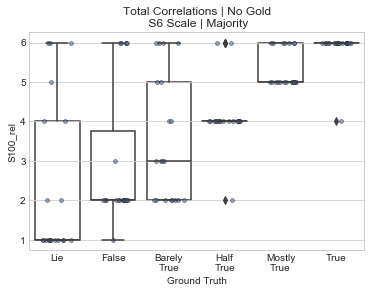

In [6]:
# S100
#df = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
# S6
df = pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')
#df =  df.dropna()
#df["S100_rel"] = df["S100_rel"].astype(int)

df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)

merged = df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()

m = {"s": 15, "alpha": alpha, 'linewidths': linewidth, "facecolor": sns.color_palette('deep')[int(6)%6],'edgecolor': 'black'}

#pages = PdfPages("../../plots/BigTask/Correlations/all_S6_majority_boxplot.pdf")

#plt.figure(figsize=(9, 6))
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, 
                 x_jitter = .28, scatter_kws = m)
sns.boxplot( x = 'rel', y = "S6_rel", data = merged, 
            boxprops = dict(facecolor = '#FFFFFF', alpha=1, zorder = 0))
ax.set_title("Total Correlations | No Gold\n S6 Scale | Majority")
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
#ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])

# axis label
ax.set(ylabel = 'S100_rel', xlabel = 'Ground Truth')
sns.despine (top=False,right=False,left=False,bottom=False)

#pages.savefig(bbox_inches='tight');pages.close();plt.show()

<h3>Con Media</h3>

1196


[Text(0,0,'Lie'),
 Text(0,0,'False'),
 Text(0,0,'Barely\nTrue'),
 Text(0,0,'Half\nTrue'),
 Text(0,0,'Mostly\nTrue'),
 Text(0,0,'True')]

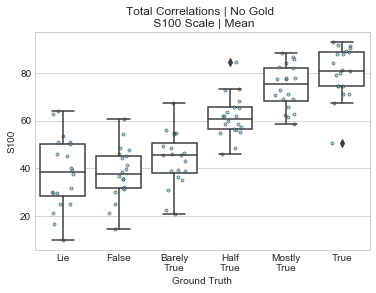

In [14]:
# S100
df = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
# S6
#df = pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')
df =  df.dropna()
df["S100_rel"] = df["S100_rel"].astype(int)


df = df[df["rel"].isin(gold_dict) == False]

df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)

merged = df[['doc_id', "S100_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()
#display(merged.head())

# S100
#pages = PdfPages("../../plots/BigTask/Correlations/all_S100_mean.pdf")
# S6
#pages = PdfPages("../../plots/BigTask/Correlations/others_S6_mean.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(5)%6],'edgecolor': 'black'}

ax = sns.regplot(x = 'rel', y = 'S100_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S100_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))   

ax.set(title= "Total Correlations | No Gold \n S100 Scale | Mean", ylabel='S100', xlabel='Ground Truth')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])

#pages.savefig(bbox_inches='tight');pages.close();plt.show()

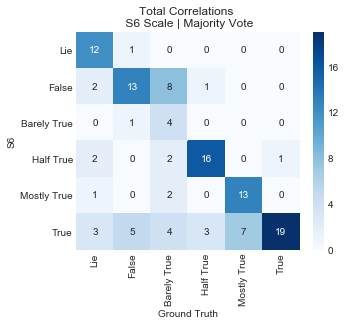

In [36]:
# MAJORITY
# S6
df = pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')
df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)

merged = df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()
#display(merged.head())
m = merged[['S6_rel', 'rel']]
m['count'] = 0
mm = m.groupby(['rel', 'S6_rel']).agg('count')['count']

f = mm.unstack()
f = f.fillna(0)
f.columns = ['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True']
f = f.transpose()

pages = PdfPages("../../plots/BigTask/Correlations/all_S6_majority.pdf")
ax = sns.heatmap(f, annot=True, cmap="Blues")
ax.set_title("Total Correlations \n S6 Scale | Majority Vote")
ax.set_yticklabels(['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True'], rotation = 0)
ax.set_xticklabels(['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True'], rotation = 90)
ax.set_xlabel('Ground Truth')
ax.set_ylabel('S6')
pages.savefig(bbox_inches='tight');pages.close();plt.show()

<h3>POLITICAL DISTINCTION </h3>

In [175]:
# S100
df = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
# S6
#df = pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')
df =  df.dropna()
df["S100_rel"] = df["S100_rel"].astype(int)

df = df[['doc_id', 'party_ln', 'S100_rel', 'rel', 'url']]
df = df[df["rel"].isin(gold_dict) == False]
#df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
    
df['worker_party'] = df.apply(lambda row: party_ln_replace(row.party_ln), axis = 1)

df['party_doc'] = df['doc_id']
df['party_doc'] = df.apply(lambda row: get_party(row.party_doc), axis = 1)
df['url'][80] = "http://www.fakeURL.com"
df['url'][373] = "http://www.fakeURL.com"
df['url'] = df.apply(lambda row: find_domain(row.url), axis = 1)
display(df.head(2))

dem_df = df.loc[df['worker_party'] == 'DEM']
rep_df = df.loc[df['worker_party'] == 'REP']

display(dem_df.head())
display(rep_df.head())

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,doc_id,party_ln,S100_rel,rel,url,worker_party,party_doc
0,REP_LIE_doc6,1,3,LIE,en.wikipedia.org,REP,REP
1,DEM_FALSE_doc1,1,6,FALSE,www.facebook.com,REP,DEM


,doc_id,party_ln,S100_rel,rel,url,worker_party,party_doc
24,DEM_BARELYTRUE_doc9,2,17,BARELYTRUE,www.washingtonpost.com,DEM,DEM
25,REP_TRUE_doc8,2,85,TRUE,www.uscourts.gov,DEM,REP
26,REP_HALFTRUE_doc10,2,24,HALFTRUE,en.wikipedia.org,DEM,REP
27,DEM_LIE_doc8,2,80,LIE,www.bostonglobe.com,DEM,DEM
28,DEM_MOSTLYTRUE_doc3,2,79,MOSTLYTRUE,www.citylab.com,DEM,DEM


,doc_id,party_ln,S100_rel,rel,url,worker_party,party_doc
0,REP_LIE_doc6,1,3,LIE,en.wikipedia.org,REP,REP
1,DEM_FALSE_doc1,1,6,FALSE,www.facebook.com,REP,DEM
3,DEM_HALFTRUE_doc3,1,2,HALFTRUE,www.politifact.com,REP,DEM
4,DEM_TRUE_doc2,1,40,TRUE,www.vanityfair.com,REP,DEM
6,REP_MOSTLYTRUE_doc5,1,93,MOSTLYTRUE,www.politifact.com,REP,REP


In [178]:
dem_df = dem_df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
merged = dem_df[['doc_id', "S100_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()
display(merged.head())
my_dict, order = get_dict2(merged, 'S100')
p_adj_S100 = get_pvalues(my_dict, order)
#print(p_adj_S100)
ttest_heat(p_adj_S100, 'S100', 'prova')

,doc_id,S100_rel,rel
0,DEM_BARELYTRUE_doc1,57.166667,2.0
1,DEM_BARELYTRUE_doc10,32.600000,2.0
2,DEM_BARELYTRUE_doc2,51.750000,2.0
3,DEM_BARELYTRUE_doc3,36.333333,2.0
4,DEM_BARELYTRUE_doc4,36.333333,2.0


c:\users\barbe\anaconda3\lib\site-packages\pandas\core\ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

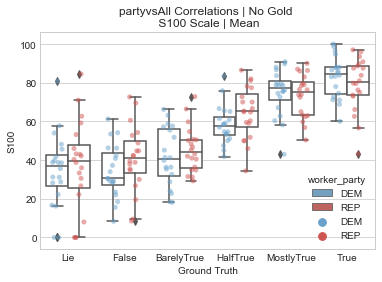

In [68]:
# S100
def corr_plot(table, cat, rel, name):
    custom = ["#6aa2cb", "#ce555146"]
    pages = PdfPages("../../plots/BigTask/Correlations/All/{}_{}_mean.pdf".format(name, rel))
    m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(5)%6],'edgecolor': 'black'}
    ax1 = sns.stripplot(x = 'rel', y = '{}_rel'.format(rel), hue = cat, data = table,
                  dodge = True, jitter = jitter, alpha = .5, palette = custom)
    ax = sns.boxplot(x = 'rel', y = '{}_rel'.format(rel), hue = cat, data = table, palette = custom, boxprops = dict(facecolor = '#FFFFFF'))   
    ax.set(title= "{} Correlations | No Gold \n {} Scale | Mean".format(name, rel),
           ylabel='{}'.format(rel), xlabel='Ground Truth')
    ax.set_xticklabels(['Lie', 'False', 'BarelyTrue', 'HalfTrue', 'MostlyTrue', 'True'])
    pages.savefig(bbox_inches='tight');pages.close();plt.show()
    

corr_plot(merged, 'worker_party', 'S100', 'partyvsAll')

[Text(0,0,'Lie'),
 Text(0,0,'False'),
 Text(0,0,'Barely\nTrue'),
 Text(0,0,'Half\nTrue'),
 Text(0,0,'Mostly\nTrue'),
 Text(0,0,'True')]

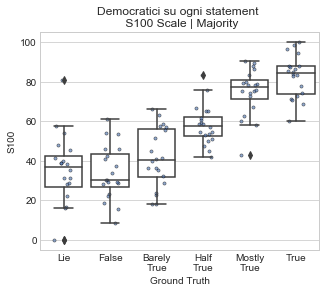

In [168]:
# DEMOCRATICI SU TUTTI GLI STATEMENT
dem_df = dem_df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
merged = dem_df[['doc_id', "S100_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()

# S100
#pages = PdfPages("../../plots/BigTask/Correlations/dem_all_S100_median.pdf")
# S6
#pages = PdfPages("../../plots/BigTask/Correlations/dem_all_S6_majority_boxplot.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(6)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S100_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S100_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))
ax.set(title = "Democratici su ogni statement \n S100 Scale | Majority", ylabel = 'S100', xlabel = 'Ground Truth')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])

#pages.savefig(bbox_inches='tight');pages.close();plt.show()

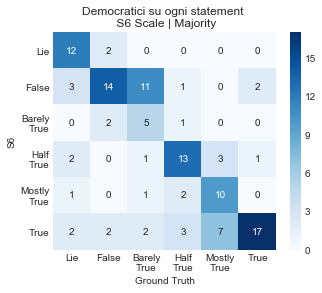

In [78]:
# DEM SU TUTTI MAJORITY | SOLO PER S6
merged = dem_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()
#display(merged.head())
m = merged[['S6_rel', 'rel']]
m['count'] = 0
mm = m.groupby(['rel', 'S6_rel']).agg('count')['count']

f = mm.unstack()
f = f.fillna(0)
f.columns = ['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True']
f = f.transpose()

pages = PdfPages("../../plots/BigTask/Correlations/dem_all_S6_majority.pdf")
ax = sns.heatmap(f, annot=True, cmap="Blues")
ax.set_title("Democratici su ogni statement \n S6 Scale | Majority")
ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xlabel('Ground Truth')
ax.set_ylabel('S6')
pages.savefig(bbox_inches='tight');pages.close();plt.show()

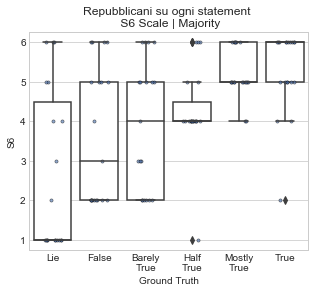

In [20]:
# REPUBBLICANI SU TUTTI GLI STATEMENT
merged = rep_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()

# S100
#pages = PdfPages("../../plots/BigTask/Correlations/rep_all_S100_median.pdf")
# S6
pages = PdfPages("../../plots/BigTask/Correlations/rep_all_S6_majority_boxplot.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(6)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))
ax.set(title= "Repubblicani su ogni statement \n S6 Scale | Majority", ylabel='S6', xlabel='Ground Truth')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

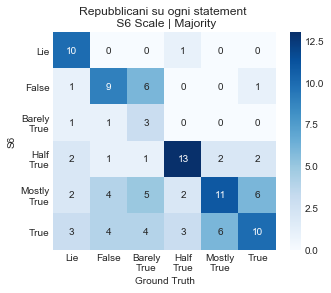

In [82]:
# REP SU TUTTI MAJORITY
merged = rep_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()
#display(merged.head())
m = merged[['S6_rel', 'rel']]
m['count'] = 0
mm = m.groupby(['rel', 'S6_rel']).agg('count')['count']

f = mm.unstack()
f = f.fillna(0)
f.columns = ['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True']
f = f.transpose()

pages = PdfPages("../../plots/BigTask/Correlations/rep_all_S6_majority.pdf")
ax = sns.heatmap(f, annot=True, cmap="Blues")
ax.set_title("Repubblicani su ogni statement \n S6 Scale | Majority")
ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xlabel('Ground Truth')
ax.set_ylabel('S6')
pages.savefig(bbox_inches='tight');pages.close();plt.show()

In [131]:

# DEM SU DEM | DEM SU REP | REP SU REP | REP SU DEM
dem_dem_df = df.loc[(df['worker_party'] == 'DEM') & (df['party_doc'] == 'DEM')]
dem_rep_df = df.loc[(df['worker_party'] == 'DEM') & (df['party_doc'] == 'REP')]
rep_rep_df = df.loc[(df['worker_party'] == 'REP') & (df['party_doc'] == 'REP')]
rep_dem_df = df.loc[(df['worker_party'] == 'REP') & (df['party_doc'] == 'DEM')]

display(dem_dem_df.head())
display(dem_rep_df.head())
display(rep_rep_df.head())
display(rep_dem_df.head())

print(dem_dem_df.shape[0])
print(dem_rep_df.shape[0])
print(rep_rep_df.shape[0])
print(rep_dem_df.shape[0])
print("\n")
print(dem_dem_df.url.str.count("www.politifact.com").sum())
print(dem_rep_df.url.str.count("www.politifact.com").sum())
print(rep_rep_df.url.str.count("www.politifact.com").sum())
print(rep_dem_df.url.str.count("www.politifact.com").sum())

,doc_id,party_ln,S100_rel,rel,url,worker_party,party_doc
24,DEM_BARELYTRUE_doc9,2,17,BARELYTRUE,www.washingtonpost.com,DEM,DEM
27,DEM_LIE_doc8,2,80,LIE,www.bostonglobe.com,DEM,DEM
28,DEM_MOSTLYTRUE_doc3,2,79,MOSTLYTRUE,www.citylab.com,DEM,DEM
33,DEM_TRUE_doc2,2,0,TRUE,www.rollcall.com,DEM,DEM
36,DEM_FALSE_doc1,2,100,FALSE,www.washingtonpost.com,DEM,DEM


,doc_id,party_ln,S100_rel,rel,url,worker_party,party_doc
25,REP_TRUE_doc8,2,85,TRUE,www.uscourts.gov,DEM,REP
26,REP_HALFTRUE_doc10,2,24,HALFTRUE,en.wikipedia.org,DEM,REP
30,REP_FALSE_doc2,2,79,FALSE,en.wikipedia.org,DEM,REP
32,REP_LIE_doc6,2,10,LIE,www.healthaffairs.org,DEM,REP
34,REP_BARELYTRUE_doc4,2,0,BARELYTRUE,www.politifact.com,DEM,REP


,doc_id,party_ln,S100_rel,rel,url,worker_party,party_doc
0,REP_LIE_doc6,1,3,LIE,en.wikipedia.org,REP,REP
6,REP_MOSTLYTRUE_doc5,1,93,MOSTLYTRUE,www.politifact.com,REP,REP
7,REP_BARELYTRUE_doc4,1,88,BARELYTRUE,www.texasstandard.org,REP,REP
8,REP_TRUE_doc8,1,100,TRUE,www.politifact.com,REP,REP
10,REP_FALSE_doc2,1,10,FALSE,www.politifact.com,REP,REP


,doc_id,party_ln,S100_rel,rel,url,worker_party,party_doc
1,DEM_FALSE_doc1,1,6,FALSE,www.facebook.com,REP,DEM
3,DEM_HALFTRUE_doc3,1,2,HALFTRUE,www.politifact.com,REP,DEM
4,DEM_TRUE_doc2,1,40,TRUE,www.vanityfair.com,REP,DEM
11,DEM_BARELYTRUE_doc9,1,19,BARELYTRUE,www.politifact.com,REP,DEM
13,DEM_MOSTLYTRUE_doc3,1,73,MOSTLYTRUE,www.politifact.com,REP,DEM


324
327
272
273


238
241
200
191


done.


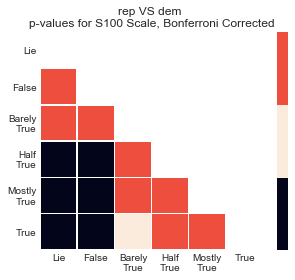

In [134]:
my_dict, order = get_dict(rep_dem_df, 'S100')
p_adj_S100 = get_pvalues(my_dict, order)
#print(p_adj_S100)
ttest_heat(p_adj_S100, 'S100', 'rep VS dem')

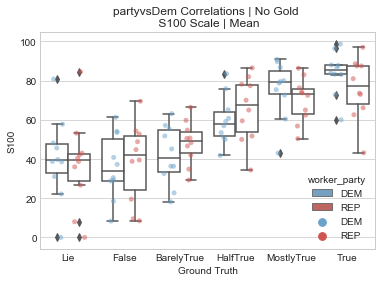

In [70]:
merged = merge_df(dem_dem_df, rep_dem_df)
corr_plot(merged, 'worker_party', 'S100', 'partyvsDem')

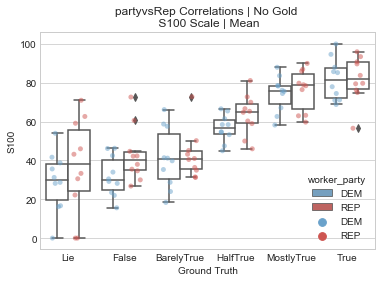

In [71]:
merged = merge_df(dem_rep_df, rep_rep_df)
corr_plot(merged, 'worker_party', 'S100', 'partyvsRep')

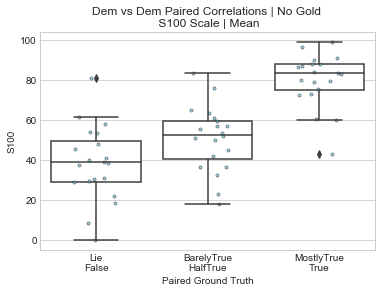

In [92]:
df = dem_dem_df
df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 0).replace('BARELYTRUE', 1).replace('HALFTRUE', 1).replace('MOSTLYTRUE', 2).replace('TRUE', 2)
#display(df.head(20))

merged = df[['doc_id', "S100_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()
# S100
pages = PdfPages("../../plots/BigTask/Correlations/Paired/demDem_paired_S100_mean.pdf")
m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(5)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S100_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S100_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))   
ax.set(title= "Dem vs Dem Paired Correlations | No Gold \n S100 Scale | Mean", ylabel='S100', xlabel='Paired Ground Truth')
ax.set_xticklabels(['Lie\nFalse', 'BarelyTrue\nHalfTrue', 'MostlyTrue\nTrue'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

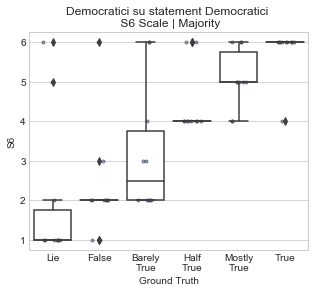

In [23]:
# DEM SU DEM | MEAN | MEDIAN
merged = dem_dem_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()

# S100
#pages = PdfPages("../../plots/BigTask/Correlations/dem_dem_S100_median.pdf")
# S6
pages = PdfPages("../../plots/BigTask/Correlations/dem_dem_S6_majority_boxplot.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(6)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))
ax.set(title= "Democratici su statement Democratici \n S6 Scale | Majority", ylabel='S6', xlabel='Ground Truth')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

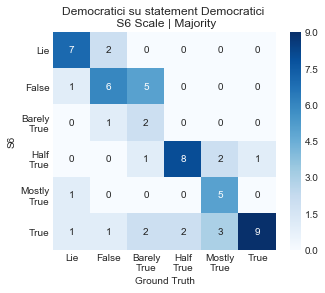

In [86]:
# DEM SU DEM | S6 MAJORITY
merged = dem_dem_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()
#display(merged.head())
m = merged[['S6_rel', 'rel']]
m['count'] = 0
mm = m.groupby(['rel', 'S6_rel']).agg('count')['count']

f = mm.unstack()
f = f.fillna(0)
f.columns = ['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True']
f = f.transpose()

pages = PdfPages("../../plots/BigTask/Correlations/dem_dem_S6_majority.pdf")
ax = sns.heatmap(f, annot=True, cmap="Blues")
ax.set_title("Democratici su statement Democratici \n S6 Scale | Majority")
ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xlabel('Ground Truth')
ax.set_ylabel('S6')
pages.savefig(bbox_inches='tight');pages.close();plt.show()

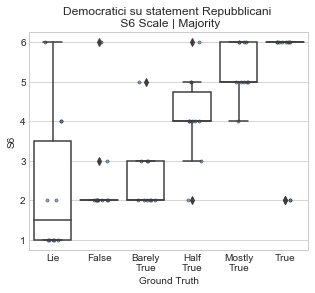

In [24]:
# DEM SU REP
merged = dem_rep_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()

# S100
#pages = PdfPages("../../plots/BigTask/Correlations/dem_rep_S100_median.pdf")
# S6
pages = PdfPages("../../plots/BigTask/Correlations/dem_rep_S6_majority_boxplot.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(6)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))   
ax.set(title = "Democratici su statement Repubblicani \n S6 Scale | Majority", ylabel = 'S6', xlabel = 'Ground Truth')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])

pages.savefig(bbox_inches='tight');pages.close();plt.show()

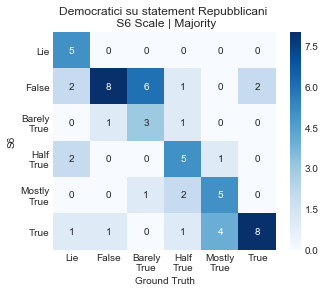

In [89]:
# DEM SU REP | MAJORITY
merged = dem_rep_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()
#display(merged.head())
m = merged[['S6_rel', 'rel']]
m['count'] = 0
mm = m.groupby(['rel', 'S6_rel']).agg('count')['count']

f = mm.unstack()
f = f.fillna(0)
f.columns = ['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True']
f = f.transpose()

pages = PdfPages("../../plots/BigTask/Correlations/dem_rep_S6_majority.pdf")
ax = sns.heatmap(f, annot=True, cmap="Blues")
ax.set_title("Democratici su statement Repubblicani \n S6 Scale | Majority")
ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xlabel('Ground Truth')
ax.set_ylabel('S6')
pages.savefig(bbox_inches='tight');pages.close();plt.show()

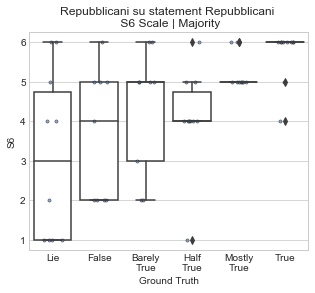

In [25]:
# REP SU REP
merged = rep_rep_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()
# S100
#pages = PdfPages("../../plots/BigTask/Correlations/rep_rep_S100_mean.pdf")
# S6
pages = PdfPages("../../plots/BigTask/Correlations/rep_rep_S6_majority_boxplot.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(6)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))   
ax.set(title= "Repubblicani su statement Repubblicani \n S6 Scale | Majority", ylabel = 'S6',xlabel='Ground Truth')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

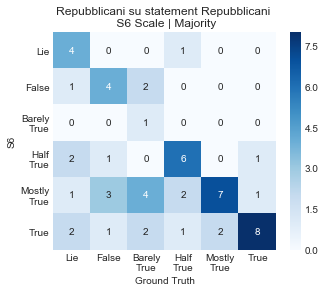

In [92]:
# REP SU REP
merged = rep_rep_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()
#display(merged.head())
m = merged[['S6_rel', 'rel']]
m['count'] = 0
mm = m.groupby(['rel', 'S6_rel']).agg('count')['count']

f = mm.unstack()
f = f.fillna(0)
f.columns = ['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True']
f = f.transpose()

pages = PdfPages("../../plots/BigTask/Correlations/rep_rep_S6_majority.pdf")
ax = sns.heatmap(f, annot=True, cmap="Blues")
ax.set_title("Repubblicani su statement Repubblicani \n S6 Scale | Majority")
ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xlabel('Ground Truth')
ax.set_ylabel('S6')
pages.savefig(bbox_inches='tight');pages.close();plt.show()

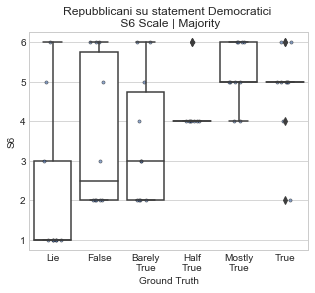

In [26]:
# REP SU DEM
merged = rep_dem_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()

# S100
#pages = PdfPages("../../plots/BigTask/Correlations/rep_dem_S100_median.pdf")
# S6
pages = PdfPages("../../plots/BigTask/Correlations/rep_dem_S6_majority_boxplot.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(6)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))  
ax.set(title= "Repubblicani su statement Democratici \n S6 Scale | Majority", ylabel = 'S6', xlabel = 'Ground Truth')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])

pages.savefig(bbox_inches='tight');pages.close();plt.show()

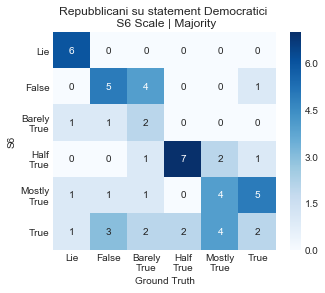

In [95]:
# REP SU DEM
merged = rep_dem_df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()
#display(merged.head())
m = merged[['S6_rel', 'rel']]
m['count'] = 0
mm = m.groupby(['rel', 'S6_rel']).agg('count')['count']

f = mm.unstack()
f = f.fillna(0)
f.columns = ['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True']
f = f.transpose()

pages = PdfPages("../../plots/BigTask/Correlations/rep_dem_S6_majority.pdf")
ax = sns.heatmap(f, annot=True, cmap="Blues")
ax.set_title("Repubblicani su statement Democratici \n S6 Scale | Majority")
ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xlabel('Ground Truth')
ax.set_ylabel('S6')
pages.savefig(bbox_inches='tight');pages.close();plt.show()

<h3>PolitiFact</h3

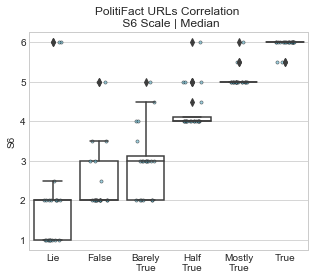

In [101]:
df = pd.read_csv('../../Task/BigTask/Poli_S6.csv')

df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)

merged = df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()
m = {"s": 15, "alpha": .7, 'linewidths': 1, "facecolor": 'none', 'edgecolor': '#2A6FCD'}
# S100
#pages = PdfPages("../../plots/BigTask/Correlations/others_rep_dem_S100.pdf")
# S6
pages = PdfPages("../../plots/BigTask/Correlations/PolitiFact/poli_S6_majority_.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(v)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))  
ax.set(title= "PolitiFact URLs Correlation \n S6 Scale | Median", ylabel='S6', xlabel='')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

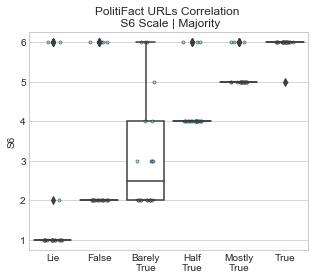

In [99]:
df = pd.read_csv('../../Task/BigTask/Poli_S6.csv')

df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)

merged = df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x: majority_vote(x)).reset_index()
m = {"s": 15, "alpha": .7, 'linewidths': 1, "facecolor": 'none', 'edgecolor': '#2A6FCD'}
# S100
#pages = PdfPages("../../plots/BigTask/Correlations/others_rep_dem_S100.pdf")
# S6
pages = PdfPages("../../plots/BigTask/Correlations/poli_S6_majority.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(v)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))  
ax.set(title= "PolitiFact URLs Correlation \n S6 Scale | Majority", ylabel='S6', xlabel='')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])

pages.savefig(bbox_inches='tight');pages.close();plt.show()

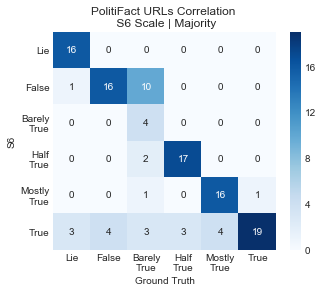

In [100]:
df = pd.read_csv('../../Task/BigTask/Poli_S6.csv')
from collections import Counter

def majority_vote(x):
    c = Counter(x)
    value, count = c.most_common()[0]
    return value

df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 1).replace('FALSE', 2).replace('BARELYTRUE', 3).replace('HALFTRUE', 4).replace('MOSTLYTRUE', 5).replace('TRUE', 6)
#df = df.replace('LIE', 'Lie').replace('FALSE', 'False').replace('BARELYTRUE', 'Barely True').replace('HALFTRUE', 'Half True').replace('MOSTLYTRUE', 'Mostly True').replace('TRUE', 'True')


merged = df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x: majority_vote(x)).reset_index()

m = merged[['S6_rel', 'rel']]
m['count'] = 0
mm = m.groupby(['rel', 'S6_rel']).agg('count')['count']

f = mm.unstack()
f = f.fillna(0)
f.columns = ['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True']

f = f.transpose()

pages = PdfPages("../../plots/BigTask/Correlations/poli_S6_heatmap_majority.pdf")

ax = sns.heatmap(f, annot=True, cmap="Blues")
ax.set_title("PolitiFact URLs Correlation \n S6 Scale | Majority")
ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xlabel('Ground Truth')
ax.set_ylabel('S6')
pages.savefig(bbox_inches='tight');pages.close();plt.show()

In [114]:
df = pd.read_csv('../../Task/BigTask/Not_Poli_S6.csv')

df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 1).replace('FALSE', 2).replace('BARELYTRUE', 3).replace('HALFTRUE', 4).replace('MOSTLYTRUE', 5).replace('TRUE', 6)

m = df[['S6_rel', 'rel']]
m['count'] = 0
mm = m.groupby(['rel', 'S6_rel']).agg('count')['count']
f = mm.unstack()
f = f.fillna(0)
#ax = sns.heatmap(f, annot=True, cmap="Blues")

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


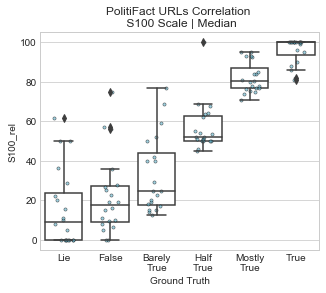

In [110]:
df = pd.read_csv('../../Task/BigTask/Poli_S100.csv')

df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)

merged = df[['doc_id', "S100_rel", 'rel']].groupby(['doc_id']).agg('median').reset_index()
m = {"s": 15, "alpha": .7, 'linewidths': 1, "facecolor": 'none', 'edgecolor': '#2A6FCD'}
# S6
pages = PdfPages("../../plots/BigTask/Correlations/PolitiFact/poli_S100_median.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(v)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S100_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S100_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))  
ax.set(title= "PolitiFact URLs Correlation \n S100 Scale | Median", ylabel='S100_rel', xlabel='Ground Truth')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])

pages.savefig(bbox_inches='tight');pages.close();plt.show()

<h3>Not PolitiFact</h3>

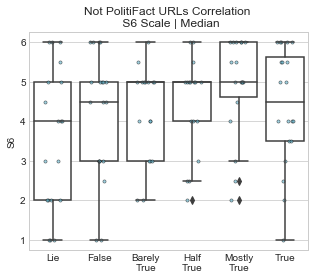

In [105]:
df = pd.read_csv('../../Task/BigTask/Not_Poli_S6.csv')

df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
#display(df)
merged = df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg('median').reset_index()
m = {"s": 15, "alpha": .7, 'linewidths': 1, "facecolor": 'none', 'edgecolor': '#2A6FCD'}
# S100
#pages = PdfPages("../../plots/BigTask/Correlations/others_rep_dem_S100.pdf")
# S6
pages = PdfPages("../../plots/BigTask/Correlations/PolitiFact/not_poli_S6_median.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(v)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))  
ax.set(title= "Not PolitiFact URLs Correlation \n S6 Scale | Median", ylabel='S6', xlabel='')
#ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

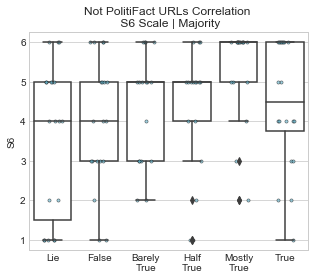

In [106]:
df = pd.read_csv('../../Task/BigTask/Not_Poli_S6.csv')

df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
#display(df)
merged = df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x:majority_vote(x)).reset_index()
m = {"s": 15, "alpha": .7, 'linewidths': 1, "facecolor": 'none', 'edgecolor': '#2A6FCD'}
# S100
#pages = PdfPages("../../plots/BigTask/Correlations/others_rep_dem_S100.pdf")
# S6
pages = PdfPages("../../plots/BigTask/Correlations/PolitiFact/not_poli_S6_majority.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(v)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))  
ax.set(title= "Not PolitiFact URLs Correlation \n S6 Scale | Majority", ylabel='S6', xlabel='')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])

pages.savefig(bbox_inches='tight');pages.close();plt.show()

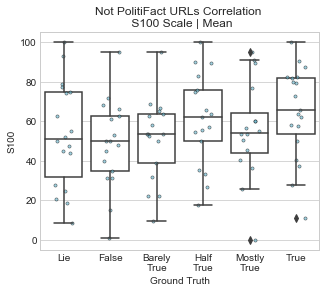

In [116]:
df = pd.read_csv('../../Task/BigTask/Not_Poli_S100.csv')

df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
#display(df)
merged = df[['doc_id', "S100_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()

m = {"s": 15, "alpha": .7, 'linewidths': 1, "facecolor": 'none', 'edgecolor': '#2A6FCD'}
# S100
#pages = PdfPages("../../plots/BigTask/Correlations/others_rep_dem_S100.pdf")
# S6
pages = PdfPages("../../plots/BigTask/Correlations/PolitiFact/not_poli_S100_mean.pdf")

m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(v)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S100_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S100_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))  
ax.set(title = "Not PolitiFact URLs Correlation \n S100 Scale | Mean", ylabel = 'S100', xlabel = 'Ground Truth')
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

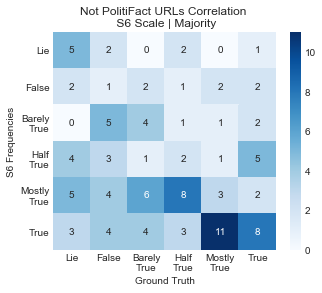

In [108]:
df = pd.read_csv('../../Task/BigTask/Not_Poli_S6.csv')

df = df[df["rel"].isin(gold_dict) == False]
#df = df.replace('LIE', 'Lie').replace('FALSE', 'False').replace('BARELYTRUE', 'Barely True').replace('HALFTRUE', 'Half True').replace('MOSTLYTRUE', 'Mostly True').replace('TRUE', 'True')
df = df.replace('LIE', 1).replace('FALSE', 2).replace('BARELYTRUE', 3).replace('HALFTRUE', 4).replace('MOSTLYTRUE', 5).replace('TRUE', 6)

merged = df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg(lambda x: majority_vote(x)).reset_index()

m = merged[['S6_rel', 'rel']]
m['count'] = 0
mm = m.groupby(['rel', 'S6_rel']).agg('count')['count']

f = mm.unstack()
f = f.fillna(0)
f.columns = ['Lie', 'False', 'Barely True', 'Half True', 'Mostly True', 'True']

f = f.transpose()

pages = PdfPages("../../plots/BigTask/Correlations/PolitiFact/not_poli_S6_heatmap_majority.pdf")

ax = sns.heatmap(f, annot=True, cmap="Blues")
ax.set_title("Not PolitiFact URLs Correlation \n S6 Scale | Majority")
ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_xlabel('Ground Truth')
ax.set_ylabel('S6 Frequencies')
pages.savefig(bbox_inches='tight');pages.close();plt.show()

<h3>Gruppi di 3</h3>

In [28]:
df100 = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
df6 = pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')

In [29]:

df100 = df100[df100["rel"].isin(gold_dict) == False]
df100 = df100.replace('LIE', 0).replace('FALSE', 0).replace('BARELYTRUE', 1).replace('HALFTRUE', 1).replace('MOSTLYTRUE', 2).replace('TRUE', 2)
display(df100.head(2))
df6 = df6[df6["rel"].isin(gold_dict) == False]
df6 = df6.replace('LIE', 0).replace('FALSE', 0).replace('BARELYTRUE', 1).replace('HALFTRUE', 1).replace('MOSTLYTRUE', 2).replace('TRUE', 2)
display(df6.head(2))

,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,position_in_task,S100_rel,justification,url,off_page_count,ip_address,time
0,unit_0,REP_LIE_doc6,0,A28KV1QXL1AV4X,2,5,3,6,3,1,2,1,1,1,3.0,"Rick Perry was governor of Texas, not Massachu...",https://en.wikipedia.org/wiki/Rick_Perry,0,74.97.48.154,59.715
1,unit_0,DEM_FALSE_doc1,0,A28KV1QXL1AV4X,2,5,3,6,3,1,2,1,1,2,6.0,Nancy Pelosi is House Majority leader and Spea...,https://www.facebook.com/NancyPelosi/,1,74.97.48.154,85.715


,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,position_in_task,S6_rel,justification,url,off_page_count,ip_address,time
0,unit_0,REP_LIE_doc6,0,AFBS8D6KBKKKY,2,3,4,3,2,2,4,1,3,1,1,"After implementation of the law, 98% of Massac...",https://en.wikipedia.org/wiki/Massachusetts_he...,0,65.35.157.98,105.615
1,unit_0,DEM_FALSE_doc1,0,AFBS8D6KBKKKY,2,3,4,3,2,2,4,1,3,2,1,She has literally cited him in the past.,https://twitchy.com/2014/11/13/jonathan-who-na...,3,65.35.157.98,133.090


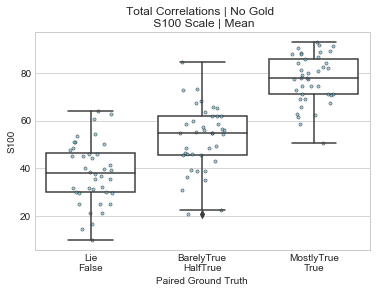

In [32]:
merged = df100[['doc_id', "S100_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()
# S100
pages = PdfPages("../../plots/BigTask/Correlations/Paired/all_paired_S100_mean.pdf")
m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(5)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S100_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S100_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))   
ax.set(title= "Total Correlations | No Gold \n S100 Scale | Mean", ylabel='S100', xlabel='Paired Ground Truth')
ax.set_xticklabels(['Lie\nFalse', 'BarelyTrue\nHalfTrue', 'MostlyTrue\nTrue'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

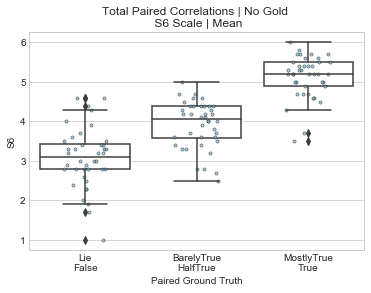

In [31]:
merged = df6[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()
#display(merged.head())

# S6
pages = PdfPages("../../plots/BigTask/Correlations/Paired/all_paired_S6_mean.pdf")
m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(5)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))   
ax.set(title= "Total Paired Correlations | No Gold \n S6 Scale | Mean", ylabel='S6', xlabel='Paired Ground Truth')
ax.set_xticklabels(['Lie\nFalse', 'BarelyTrue\nHalfTrue', 'MostlyTrue\nTrue'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

<h3>PolitiFact Paired</h3>

In [46]:
df100Poli = pd.read_csv('../../Task/BigTask/Poli_S100.csv')
df100NotPoli = pd.read_csv('../../Task/BigTask/Not_Poli_S100.csv')
df6Poli = pd.read_csv('../../Task/BigTask/Poli_S6.csv')
df6NotPoli = pd.read_csv('../../Task/BigTask/Not_Poli_S6.csv')

,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,position_in_task,S100_rel,justification,url,off_page_count,ip_address,time
0,unit_0,DEM_HALFTRUE_doc3,1,A28KV1QXL1AV4X,2,5,3,6,3,1,2,1,1,4,2.0,Looks like it went up 170%.according to Politi...,www.politifact.com,1,74.97.48.154,147.263
1,unit_0,REP_MOSTLYTRUE_doc5,2,A28KV1QXL1AV4X,2,5,3,6,3,1,2,1,1,7,93.0,"He said that in a January 28, 2008, speech.",www.politifact.com,3,74.97.48.154,125.867


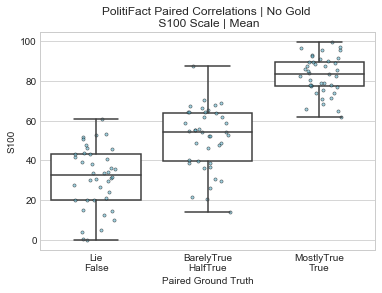

In [50]:
df = df100Poli
df.dropna()
df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 0).replace('BARELYTRUE', 1).replace('HALFTRUE', 1).replace('MOSTLYTRUE', 2).replace('TRUE', 2)
display(df.head(2))

merged = df[['doc_id', "S100_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()
# S100
pages = PdfPages("../../plots/BigTask/Correlations/Paired/poli_paired_S100_mean.pdf")
m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(5)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S100_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S100_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))   
ax.set(title= "PolitiFact Paired Correlations | No Gold \n S100 Scale | Mean", ylabel='S100', xlabel='Paired Ground Truth')
ax.set_xticklabels(['Lie\nFalse', 'BarelyTrue\nHalfTrue', 'MostlyTrue\nTrue'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,...,elections,teaparty,position_in_task,S100_rel,justification,url,off_page_count,ip_address,time,_merge
0,unit_0,REP_LIE_doc6,0,A28KV1QXL1AV4X,2,5,3,6,3,1,...,1,1,1,3.0,"Rick Perry was governor of Texas, not Massachu...",en.wikipedia.org,0,74.97.48.154,59.715,left_only
1,unit_0,DEM_FALSE_doc1,0,A28KV1QXL1AV4X,2,5,3,6,3,1,...,1,1,2,6.0,Nancy Pelosi is House Majority leader and Spea...,www.facebook.com,1,74.97.48.154,85.715,left_only
3,unit_0,DEM_TRUE_doc2,2,A28KV1QXL1AV4X,2,5,3,6,3,1,...,1,1,5,40.0,I cannot find anything that supports this as f...,www.vanityfair.com,3,74.97.48.154,291.685,left_only
5,unit_0,REP_BARELYTRUE_doc4,1,A28KV1QXL1AV4X,2,5,3,6,3,1,...,1,1,8,88.0,Politifact confirms this.,www.texasstandard.org,2,74.97.48.154,78.217,left_only
8,unit_2,DEM_TRUE_doc2,2,A3LMA3YJDQUZP2,1,4,3,9,1,1,...,1,1,2,0.0,nytimes is a good source usually,www.nytimes.com,1,24.228.128.135,67.948,left_only


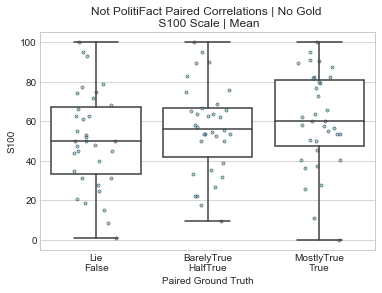

In [49]:
df = df100NotPoli
df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 0).replace('BARELYTRUE', 1).replace('HALFTRUE', 1).replace('MOSTLYTRUE', 2).replace('TRUE', 2)
display(df.head())

merged = df[['doc_id', "S100_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()
# S100
pages = PdfPages("../../plots/BigTask/Correlations/Paired/notPoli_paired_S100_mean.pdf")
m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(5)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S100_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S100_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))   
ax.set(title= "Not PolitiFact Paired Correlations | No Gold \n S100 Scale | Mean", ylabel='S100', xlabel='Paired Ground Truth')
ax.set_xticklabels(['Lie\nFalse', 'BarelyTrue\nHalfTrue', 'MostlyTrue\nTrue'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,position_in_task,S6_rel,justification,url,off_page_count,ip_address,time
0,unit_0,DEM_HALFTRUE_doc3,1,AFBS8D6KBKKKY,2,3,4,3,2,2,4,1,3,4,4,"It was found by IFC that yes, water rates did ...",www.politifact.com,6,65.35.157.98,152.994
1,unit_0,REP_MOSTLYTRUE_doc5,2,AFBS8D6KBKKKY,2,3,4,3,2,2,4,1,3,7,5,His turnaround was a pretty big one and well k...,www.politifact.com,2,65.35.157.98,117.847


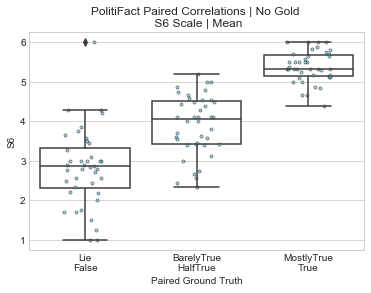

In [52]:
df = df6Poli
df.dropna()
df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 0).replace('BARELYTRUE', 1).replace('HALFTRUE', 1).replace('MOSTLYTRUE', 2).replace('TRUE', 2)
display(df.head(2))

merged = df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()
# S100
pages = PdfPages("../../plots/BigTask/Correlations/Paired/poli_paired_S6_mean.pdf")
m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(5)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))   
ax.set(title= "PolitiFact Paired Correlations | No Gold \n S6 Scale | Mean", ylabel='S6', xlabel='Paired Ground Truth')
ax.set_xticklabels(['Lie\nFalse', 'BarelyTrue\nHalfTrue', 'MostlyTrue\nTrue'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()

,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,...,elections,teaparty,position_in_task,S6_rel,justification,url,off_page_count,ip_address,time,_merge
0,unit_0,REP_LIE_doc6,0,AFBS8D6KBKKKY,2,3,4,3,2,2,...,1,3,1,1,"After implementation of the law, 98% of Massac...",en.wikipedia.org,0,65.35.157.98,105.615,left_only
1,unit_0,DEM_FALSE_doc1,0,AFBS8D6KBKKKY,2,3,4,3,2,2,...,1,3,2,1,She has literally cited him in the past.,twitchy.com,3,65.35.157.98,133.090,left_only
2,unit_0,DEM_TRUE_doc2,2,AFBS8D6KBKKKY,2,3,4,3,2,2,...,1,3,5,2,Ryan sounds like he really does regret ever su...,www.vanityfair.com,3,65.35.157.98,122.103,left_only
3,unit_1,REP_TRUE_doc8,2,A1HU0I8CI303XM,2,3,5,7,3,1,...,1,1,1,5,ITS MOSTLY CRT,en.wikipedia.org,0,192.3.161.207,414.396,left_only
4,unit_1,REP_FALSE_doc2,0,A1HU0I8CI303XM,2,3,5,7,3,1,...,1,1,3,6,ITS VERY INTERESTING,en.wikipedia.org,5,192.3.161.207,139.195,left_only


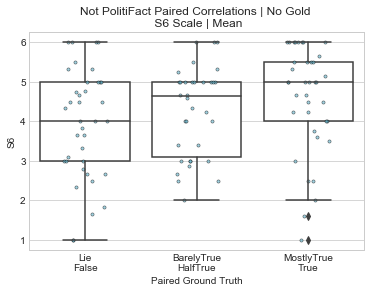

In [53]:
df = df6NotPoli
df = df[df["rel"].isin(gold_dict) == False]
df = df.replace('LIE', 0).replace('FALSE', 0).replace('BARELYTRUE', 1).replace('HALFTRUE', 1).replace('MOSTLYTRUE', 2).replace('TRUE', 2)
display(df.head())

merged = df[['doc_id', "S6_rel", 'rel']].groupby(['doc_id']).agg('mean').reset_index()
# S100
pages = PdfPages("../../plots/BigTask/Correlations/Paired/notPoli_paired_S6_mean.pdf")
m = {"s": size,"alpha":alpha,'linewidths':linewidth,"facecolor": sns.color_palette('deep')[int(5)%6],'edgecolor': 'black'}
ax = sns.regplot(x = 'rel', y = 'S6_rel', data = merged, fit_reg = False, x_jitter = jitter, scatter_kws = m,)
sns.boxplot(x = 'rel', y = 'S6_rel', data = merged,  boxprops = dict(facecolor = '#FFFFFF'))   
ax.set(title= "Not PolitiFact Paired Correlations | No Gold \n S6 Scale | Mean", ylabel='S6', xlabel='Paired Ground Truth')
ax.set_xticklabels(['Lie\nFalse', 'BarelyTrue\nHalfTrue', 'MostlyTrue\nTrue'])
pages.savefig(bbox_inches='tight');pages.close();plt.show()